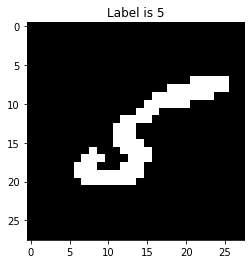

ANN result: tensor([[-22.,   0.,  -1., -28.,   1.,  13., -27., -29.,   6., -30.]],
       grad_fn=<MmBackward0>)
simulating ANN of layers [784, 800, 400, 10]
creating 784 nodes
creating 800 nodes
connecting 784 neurons to 800 neurons
this took 0.8307454820000002 seconds
creating 400 nodes
connecting 800 neurons to 400 neurons
this took 0.670333673 seconds
creating 10 nodes
connecting 400 neurons to 10 neurons
this took 0.09236326399999939 seconds
creating stimulation
starting to record
for 0 found 0 spikes 
for 1 found 0 spikes 
for 2 found 13 spikes of frequency 2.6749999999999994
for 3 found 0 spikes 
for 4 found 4 spikes of frequency 2.600000000000001
for 5 found 13 spikes of frequency 2.2583333333333337
for 6 found 0 spikes 
for 7 found 0 spikes 
for 8 found 13 spikes of frequency 2.391666666666667
for 9 found 0 spikes 
simulation result:


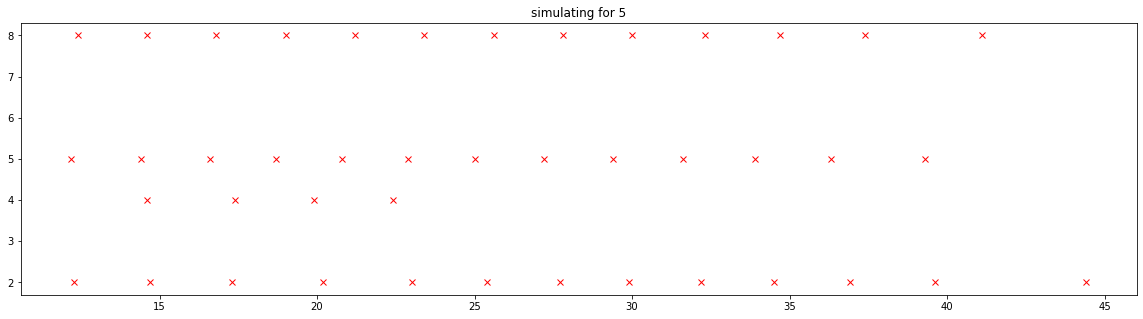

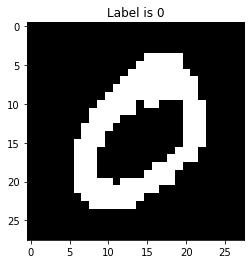

ANN result: tensor([[ 35., -15., -10., -12., -14., -14.,  -7., -17.,  -4., -18.]],
       grad_fn=<MmBackward0>)
simulating ANN of layers [784, 800, 400, 10]
creating 784 nodes
creating 800 nodes
connecting 784 neurons to 800 neurons
this took 0.8474104989999915 seconds
creating 400 nodes
connecting 800 neurons to 400 neurons
this took 0.5388427520000079 seconds
creating 10 nodes
connecting 400 neurons to 10 neurons
this took 0.08779821899999263 seconds
creating stimulation
starting to record
for 0 found 16 spikes of frequency 2.326666666666667
for 1 found 0 spikes 
for 2 found 0 spikes 
for 3 found 0 spikes 
for 4 found 0 spikes 
for 5 found 0 spikes 
for 6 found 0 spikes 
for 7 found 0 spikes 
for 8 found 0 spikes 
for 9 found 0 spikes 
simulation result:


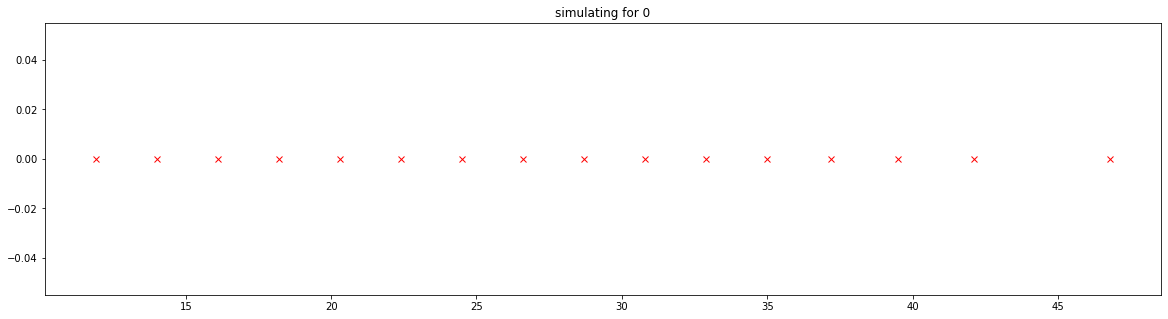

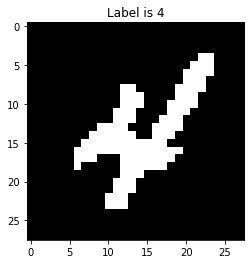

ANN result: tensor([[ -5., -11.,  11., -20.,  39.,  20.,  -5.,  -8.,  19.,  -7.]],
       grad_fn=<MmBackward0>)
simulating ANN of layers [784, 800, 400, 10]
creating 784 nodes
creating 800 nodes
connecting 784 neurons to 800 neurons
this took 0.8317631750000203 seconds
creating 400 nodes
connecting 800 neurons to 400 neurons
this took 0.6498665559999779 seconds
creating 10 nodes
connecting 400 neurons to 10 neurons
this took 0.1268332920000148 seconds
creating stimulation
starting to record
for 0 found 0 spikes 
for 1 found 0 spikes 
for 2 found 7 spikes of frequency 2.466666666666667
for 3 found 0 spikes 
for 4 found 15 spikes of frequency 2.335714285714286
for 5 found 13 spikes of frequency 2.358333333333334
for 6 found 0 spikes 
for 7 found 0 spikes 
for 8 found 10 spikes of frequency 2.1666666666666665
for 9 found 0 spikes 
simulation result:


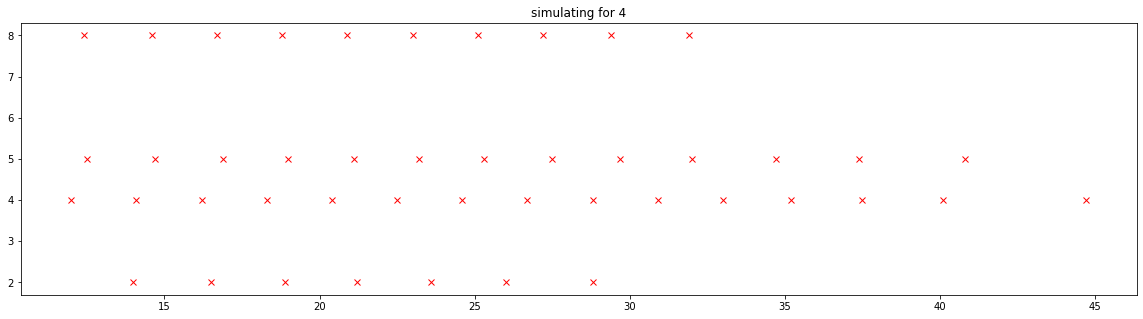

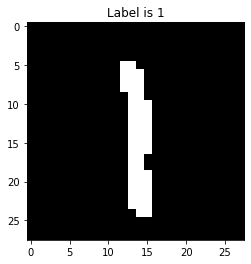

ANN result: tensor([[-22.,  26., -18.,  -9., -17., -17.,  -8., -14., -10., -12.]],
       grad_fn=<MmBackward0>)
simulating ANN of layers [784, 800, 400, 10]
creating 784 nodes
creating 800 nodes
connecting 784 neurons to 800 neurons
this took 0.9143389730000138 seconds
creating 400 nodes
connecting 800 neurons to 400 neurons
this took 0.6198135960000002 seconds
creating 10 nodes
connecting 400 neurons to 10 neurons
this took 0.09005943200000388 seconds
creating stimulation
starting to record
for 0 found 0 spikes 
for 1 found 14 spikes of frequency 2.2076923076923074
for 2 found 0 spikes 
for 3 found 0 spikes 
for 4 found 0 spikes 
for 5 found 0 spikes 
for 6 found 0 spikes 
for 7 found 0 spikes 
for 8 found 0 spikes 
for 9 found 0 spikes 
simulation result:


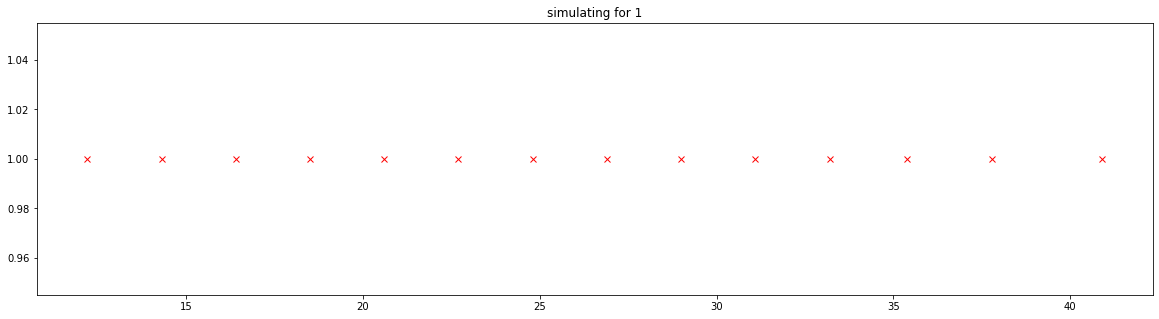

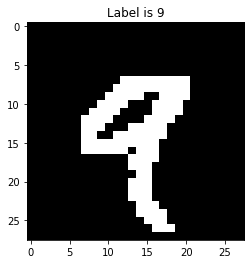

In [ ]:
import torch
import modules.model2sim as sim

import torch
import torch.nn as nn
import numpy as np

class customLoss(nn.Module):
    def __init__(self, p=0.3):
        super().__init__()
        self.p = p
        self.cost = nn.CrossEntropyLoss()
        self.cost2 = nn.L1Loss()

    def forward(self, output, labels, scale=1):
        scale_wrong = max(sum(output[0])/len(output[0]), 10) * scale
        scale_true = scale_wrong * 3
        tempLabels = torch.ones_like(output)* -1 * scale_wrong
        for i in range(labels.size(0)):
            j = labels[i]
            tempLabels[i,j] = scale_true 
        output_softmax = nn.LogSoftmax()(output)
        return self.p    * self.cost2(output, tempLabels) \
            + (1-self.p) * self.cost(output_softmax,labels)


#criterion = nn.CrossEntropyLoss()
criterion = customLoss()

def Binarize(tensor, include_zero = True, minSig=3):
    if include_zero:
        P_std = 0.25
        up_lim = torch.min(0 + P_std*tensor.std(), torch.ones_like(tensor)*minSig)
        down_lim = torch.max(0 - P_std*tensor.std(), -1*torch.ones_like(tensor)*minSig)
        up_v = (tensor>up_lim).float()
        down_v = (tensor<down_lim).float().mul(-1)
        return (up_v + down_v)
    else:
        return tensor.sign()

class BinarizeLinear(nn.Linear):

    def __init__(self, *kargs, **kwargs):
        super(BinarizeLinear, self).__init__(*kargs, **kwargs)

    def forward(self, input):

        if input.size(1) != 784:
            input.data=Binarize(input.data)
        if not hasattr(self.weight,'org'):
            self.weight.org=self.weight.data.clone()
        self.weight.data=Binarize(self.weight.org)
        out = nn.functional.linear(input, self.weight)
        if not self.bias is None:
            self.bias.org=self.bias.data.clone()
            out += self.bias.view(1, -1).expand_as(out)

        return out

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = BinarizeLinear(784, 400, bias=False)
        self.bn1 = nn.BatchNorm1d(400)
        self.htanh1 = nn.Hardtanh()
        self.fc3 = BinarizeLinear(400, 200, bias=False)
        self.bn3 = nn.BatchNorm1d(200)
        self.htanh3 = nn.Hardtanh()
        self.fc4 = BinarizeLinear(200, 10, bias=False)
        self.logsoftmax=nn.LogSoftmax()

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x
"""
    def test(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x"""



model = Net()
model.load_state_dict(torch.load("trained_models/test-customloss1-FullData.pt",map_location=torch.device('cpu')))
model.eval()
res, model_act = sim.testMNIST(model)

In [ ]:
parse, sum = sim.testSim(res, model_act,4,1,4)
pprint(parse)
print("sum:",sum)